In [1]:
# Common packages
import os,sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from importlib import reload 
import pickle 
from scipy import stats
from statannotations.Annotator import Annotator

In [2]:
sns.set_context("paper",font_scale=1.5, rc={"lines.linewidth":2})
sns.set_theme(style="ticks", color_codes=True)
sns.set_style("white")

In [3]:
# Import the cell cycle phase file
cell_cycle = pd.read_csv('./220419_stemness_cluster.csv')
clusters = cell_cycle.rename(columns={'Unnamed: 0':'cellBC', 'manual':'cluster'})

In [4]:
# Read in the final trios 
quad = pd.read_csv('scTRIP_final_tiro_merged.csv')
quad = quad.drop_duplicates()

In [5]:
# Message the cell cycle phase clusters into the form of the final trios 
clusters[['cellBC_new', 'rep']] = clusters['cellBC'].str.split('-',1, expand=True)
clusters['cellBC_new'] =  clusters['cellBC_new'].mask(clusters['rep'].eq('1-0'), clusters['cellBC_new']+ '-1')
clusters['cellBC_new'] =  clusters['cellBC_new'].mask(clusters['rep'].eq('1-1'), clusters['cellBC_new']+ '-2')
clusters = clusters[['cellBC_new', 'cluster']]
clusters = clusters.rename(columns = {'cellBC_new':'cellBC'})

In [6]:
# Function for counting the cells in G1 phase vs S/G2/M phase
def count_cells(pBC_exp_df, cell_cluster):
    trip_list = pBC_exp_df.tBC.unique().tolist()
    pop_list = []
    for trip in trip_list:
        data_slice = pBC_exp_df[pBC_exp_df['tBC'] == trip]
        cell_list = list(set(data_slice['cellBC']))
        # slice the cell_cluster list
        cluster_slice = cell_cluster.loc[cell_cluster['cellBC'].isin(cell_list)]
        total_cells = len(set(cluster_slice.cellBC))
        # Count the number of cells in G1
        diff_cells_length = len(set(cluster_slice[cluster_slice['cluster'] == 'Diff'].cellBC))
        # Count the number of cells in G2
        cd24_cells_length = len(set(cluster_slice[cluster_slice['cluster'] == 'CD24'].cellBC))
        if diff_cells_length > 30 and cd24_cells_length > 30:
        #if len(cell_list) > 50:
            pop_list.append([trip, diff_cells_length/total_cells, cd24_cells_length/total_cells, total_cells])
    pop_df = pd.DataFrame(pop_list, columns = ['tBC', 'diff_prop', 'cd24_prop',  'total_cells'])
    return pop_df

In [7]:
trip_phase = count_cells(quad, clusters)

In [ ]:
len(set(trip_phase.tBC))

345

In [ ]:
# trip_phase.to_csv('220419_trip_stem.csv')

In [ ]:
# Function to extract mean, variance with 
def mean_exp_by_cluster(pBC_exp_df, cell_cluster):
    ## Deal with cell types
    clusters =  list(set(cell_cluster['cluster']))
    tBCs = list(set(pBC_exp_df['tBC']))
    pop_df = pd.DataFrame(columns = ['tBC', 'mean', 'variance', 'phase'] )
    for cluster in clusters:
        cell_list = cell_cluster.loc[cell_cluster.cluster == cluster, 'cellBC'].to_list()
        df_slice = pBC_exp_df.loc[pBC_exp_df.cellBC.isin(cell_list)]
        slice_df = return_pBC_mean_exp_percell(df_slice, str(cluster))
        pop_df = pop_df.append(slice_df, ignore_index=True)
    return pop_df

def return_pBC_mean_exp_percell(cell_pBC_exp, key_word):
    tBC_list = list(set(cell_pBC_exp['tBC'].to_list()))
    pop_list = []
    for inx, tBC in enumerate(tBC_list):
        if inx%50 == 0: 
            print(f'We are dealing with {inx}. ')
        prom_df = cell_pBC_exp[cell_pBC_exp['tBC'] == tBC]
        cell_list = list(set(prom_df['cellBC'].to_list()))
        cell_exp_list = []
        for cell in cell_list:
            cell_slice = prom_df[prom_df['cellBC'] == cell]
            cell_mean = len(set(cell_slice['umi']))
            cell_exp_list.append(cell_mean)
        if len(cell_exp_list) > 50:
            prom_pBC_auc = np.sum(cell_exp_list)
            prom_pBC_mean = np.mean(cell_exp_list)
            prom_pBC_diff = np.max(cell_exp_list) - np.min(cell_exp_list)
            prom_pBC_mad = stats.median_abs_deviation(cell_exp_list)
            prom_pBC_iqr = stats.iqr(cell_exp_list)
            prom_pBC_var = np.var(cell_exp_list)
            prom_pBC_length = len(cell_exp_list)
            pop_list.append([tBC, prom_pBC_mean, prom_pBC_auc, prom_pBC_mad, prom_pBC_iqr, prom_pBC_var,prom_pBC_length, key_word, prom_pBC_diff])
    pop_df = pd.DataFrame(pop_list, columns = ['tBC', 'mean', 'auc', 'mad', 'iqr', 'variance', 'nCells','phase', 'exp_diff'])
    return pop_df

In [ ]:
trip_stem_exp = mean_exp_by_cluster(quad, clusters)

We are dealing with 0. 
We are dealing with 50. 
We are dealing with 100. 
We are dealing with 150. 
We are dealing with 200. 
We are dealing with 250. 
We are dealing with 300. 
We are dealing with 350. 
We are dealing with 400. 
We are dealing with 450. 
We are dealing with 500. 
We are dealing with 550. 
We are dealing with 0. 
We are dealing with 50. 
We are dealing with 100. 
We are dealing with 150. 
We are dealing with 200. 
We are dealing with 250. 
We are dealing with 300. 
We are dealing with 350. 
We are dealing with 400. 
We are dealing with 450. 
We are dealing with 500. 
We are dealing with 550. 


In [ ]:
len(trip_stem_exp.tBC.unique())

482

In [ ]:
# Let's add the weighted mean to the tBC per phase
pop_df = pd.DataFrame(columns = ['tBC', 'mean', 'auc', 'mad', 'variance', 'nCells', 'phase', 'w_mean', 'w_auc' ,'prop', 'exp_diff'])
tBC_list = list(set(trip_stem_exp.tBC.to_list()))
pop_list = []
for tBC in tBC_list:
    slice_df = trip_stem_exp[trip_stem_exp['tBC'] == tBC]
    cell_sum = slice_df.nCells.sum()
    slice_df['prop'] = slice_df['nCells']/cell_sum
    slice_df['w_mean'] = slice_df['mean'] * slice_df['nCells']/cell_sum
    slice_df['w_auc'] = slice_df['auc'] * slice_df['nCells']/cell_sum
    # slice_df['w_variance'] = (slice_df['variance'].sum() + slice_df['mean'].sum()) * slice_df['nCells']/cell_sum - (slice_df['mean'])
    # slice_df['min'] = slice_df['w_variance']/(slice_df['w_mean']**2.9)
    slice_df['min'] = slice_df['iqr']/(slice_df['mean']**2.9)
    pop_df = pop_df.append(slice_df, ignore_index=True)

<ipython-input-21-304556f33b8f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slice_df['prop'] = slice_df['nCells']/cell_sum
<ipython-input-21-304556f33b8f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slice_df['w_mean'] = slice_df['mean'] * slice_df['nCells']/cell_sum
<ipython-input-21-304556f33b8f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

c:\Users\Rilakkuma\Miniconda3\envs\jupyter\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 82.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Rilakkuma\Miniconda3\envs\jupyter\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 49.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


ValueError: provided too many kwargs, can only pass {'basex', 'subsx', nonposx'} or {'basey', 'subsy', nonposy'}.  You passed {'basex': 2}

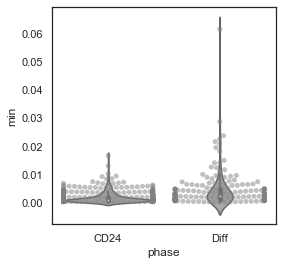

In [26]:
fig = plt.figure(figsize = (4,4))
x = 'phase'
y = 'min'
order = ['CD24', 'Diff']
pairs = [('CD24', 'Diff')]
ax = sns.violinplot(x = x, y = y, order = order, data = pop_df,color = 'darkgrey')
ax = sns.swarmplot(x = x, y = y, order = order, data = pop_df, color = 'grey', alpha = 0.5)
annotator = Annotator(ax, pairs, data=pop_df, x=x, y=y, order=order)
# ax.set_yscale('log', basex = 2)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()
sns.despine()
plt.tight_layout()
plt.xlabel('Cell Cycle Phase')
plt.ylabel('MIN')
#plt.savefig('220419_scTRIP_stem_MIN.pdf', dpi = 300)
plt.show()

c:\Users\Rilakkuma\Miniconda3\envs\jupyter\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 82.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\Rilakkuma\Miniconda3\envs\jupyter\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 75.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CD24 vs. Diff: Mann-Whitney-Wilcoxon test two-sided, P_val:3.369e-16 U_stat=6.428e+04


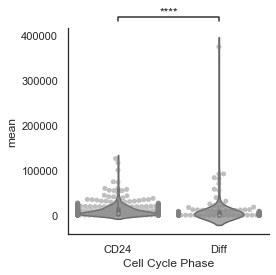

In [23]:
fig = plt.figure(figsize = (4,4))
x = 'phase'
y = 'variance'
order = ['CD24', 'Diff']
pairs = [('CD24', 'Diff')]
ax = sns.violinplot(x = x, y = y, order = order, data = pop_df,color = 'darkgrey')
ax = sns.swarmplot(x = x, y = y, order = order, data = pop_df, color = 'grey', alpha = 0.5)
annotator = Annotator(ax, pairs, data=pop_df, x=x, y=y, order=order)
#ax.set_yscale('log', base = 2)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()
sns.despine()
plt.tight_layout()
plt.xlabel('Cell Cycle Phase')
plt.ylabel('mean')
#plt.savefig('220419_scTRIP_stem_mean.pdf', dpi = 300)
plt.show()